In [1]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

Cloning into 'Eunomia'...
remote: Enumerating objects: 532, done.
remote: Counting objects: 100% (532/532), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 532 (delta 396), reused 458 (delta 322), pack-reused 0
Receiving objects: 100% (532/532), 3.49 MiB | 2.29 MiB/s, done.
Resolving deltas: 100% (396/396), done.


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
from Eunomia.degree import *
from Eunomia.experiments import *
import networkx as nx
import numpy as np

pyro.set_rng_seed(1)

In [16]:
def evaluate_coalition(coalition, effectifs):
    return np.where(effectifs[:, coalition].sum(axis = 1) > 0.5)[0].shape[0]

def compute_data(n_partis, evaluation_function, effectifs):
    alternatives = [sparse_to_alt(tuple(i), n_partis) for i in generate_additive_theta(n_partis,n_partis - 1)]
    theta = [tuple(i) for i in generate_additive_theta(n_partis,n_partis-1)]
    ranks = []
    for a in alternatives:
        ranks.append(evaluation_function(alt_to_sparse(a), effectifs))
    alternatives = np.array(alternatives)
    ranks = np.array(ranks)
    preferences = PreferenceModel(alternatives, ranks)
    data = preferences.generate_preference_matrix(theta)
    data = torch.tensor(data).float()
    return data ,theta

def plot_gaussians(means, stds, labels = None):
    if not labels:
        labels = [str(i) for i in range(means.shape[0])]
    # Create a range of x values
    x = np.linspace(min(means) - 3*max(stds), max(means) + 3*max(stds), 1000)

    # Plot each Gaussian
    for mean, std, label in zip(means, stds, labels):
        y = norm.pdf(x, mean, std)
        plt.plot(x, y, label=label)

    plt.xlabel('Value')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()
    


def linear_scaling(x):
    return x / x.sum()

def pol_scaling(x , degree = 3):
    y = np.power(x, degree)
    return y / y.sum()


def scale(suffrages, scaling_functions):
    nsf = []
    for i in range(suffrages.shape[0]):
        nsf.append(scaling_functions[i](suffrages[i, :]))
    return np.array(nsf)


In [17]:


def coalition_effectifs(coalition, effectifs, affinities):
    edges, weights = maximum_spanning_tree_subset(affinities, coalition)
    p = np.prod(weights)
    L = []
    for chamber_id in range(effectifs.shape[0]):
        L.append(effectifs[chamber_id, coalition].sum()*p)
    return np.array(L)


def coalition_evaluation(c, effectifs, sim_matrix, n = 100):
    communication_graphs = sample_binary_matrices(sim_matrix, n)
    vals = []
    totals = effectifs[:, c].sum(axis = 1)
    sgn = (sim_matrix > 0).astype(int)
    for i in range(effectifs.shape[0]):
        for j in c:
            sgn[i,j] = 0
            sgn[j,i] = 0
    cnns = find_connected_components(sgn)
    max_adv = max([effectifs[:, k].sum(axis = 1)[0] for k in cnns])
    c_effectifs = effectifs[:, c].sum(axis = 1)
    for L in communication_graphs:
        i = []
        if not are_vertices_connected(L, c):
            vals.append(0)
            continue
        i.append(c_effectifs[0] / totals[0])
        if c_effectifs[1] > 0.5*totals[1]:
            i.append(1)
        elif c_effectifs[0] > max_adv:
            i.append(2)
        elif c_effectifs[0] > 0.5*totals[0]:
            i.append(4)
        elif c_effectifs[1] > 0.5*totals[1] and c_effectifs[0] > 0.5*totals[0]:
            i.append(8)
        elif c_effectifs[1] > 0.5*totals[1] and c_effectifs[0] > 0.5*totals[1] and c_effectifs[0] + c_effectifs[1] > (3.0/5.0)*totals.sum():
            i.append(16)
        vals.append(max(i))
    return 0


def maximum_spanning_tree_subset(adj_matrix, vertices):
    # Number of vertices
    n = len(adj_matrix)

    # Create an empty graph
    G = nx.Graph()

    # Add nodes and edges to the graph
    for i in range(n):
        for j in range(i+1, n):
            G.add_edge(i, j, weight=-adj_matrix[i][j])  # Negate weight for maximum spanning tree

    # Create a subgraph with only the specified vertices
    subgraph = G.subgraph(vertices)

    # Compute the maximum spanning tree (inverted minimum spanning tree)
    mst = nx.minimum_spanning_tree(subgraph, algorithm='kruskal')

    # Negate the weights back and collect edges and weights
    edges = []
    weights = []
    for (u, v, wt) in mst.edges.data('weight'):
        edges.append((u, v))
        weights.append(-wt)

    return edges, weights

In [18]:
with open("Eunomia/data/parliament_analysis.json", 'r') as json_file:
    votes = json.load(json_file)

In [19]:
groups = votes["groups"]
ea = np.array(votes["effectifs_assemblee"])
es = np.array(votes["effectifs_senat"])

es[5] = 62
es[8] = 18

for i, g,s in zip(np.arange(ea.shape[0]), groups, es):
    print(i, g,s)

0 Renaissance 23
1 Rassemblement National 0
2 La France insoumise - Nouvelle Union Populaire écologique et sociale 0
3 Les Républicains 189
4 Démocrate (MoDem et Indépendants) 9
5 Socialistes et apparentés 62
6 Horizons et apparentés 9
7 Écologiste - NUPES 16
8 Gauche démocrate et républicaine - NUPES 18
9 Libertés, Indépendants, Outre-mer et Territoires 18
10 Non inscrits 5


In [7]:
es.sum()

349

In [20]:
groups = votes["groups"]
ea = np.array(votes["effectifs_assemblee"])
es = np.array(votes["effectifs_senat"])
effectifs = np.array([
    ea,
    es,
])
NUPES = [2,5,7,8]
ENSEMBLE = [0,4,6]


sim_mat = np.array(votes["similarity_matrix"]).mean(axis = 0)

for x in ENSEMBLE:
    for y in ENSEMBLE:
        sim_mat[x,y] = 1
        sim_mat[y,x] = 1

for x in [i for i in range(11) if i not in [1,3]]:
    sim_mat[x,1] = 0
    sim_mat[1,x] = 0
    

In [21]:
data, theta = create_data(effectifs.shape[1],
                          lambda c:coalition_evaluation(c, effectifs, sim_mat),
                          k = 1
                          )
data.shape

NameError: name 'create_data' is not defined

In [15]:
sigma_w = 1e-1
sigma_p = 1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [01:30, 27.53it/s, step size=1.39e-01, acc. prob=0.828]


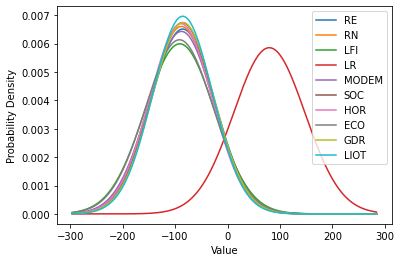

In [16]:
svs = np.array([compute_semivalues(sim_mat.shape[0], theta, weights, lambda x:1)for weights in sampled_weights])
means, stds = svs.mean(axis = 0), svs.std(axis = 0)
groups = ["RE", "RN", "LFI", "LR", "MODEM", "SOC", "HOR", "ECO", "GDR", "LIOT"]
plot_gaussians(means, stds, labels = groups)

In [ ]:
for g,m, std in zip(groups, means, stds):
    print(g, m, std)

In [22]:
def are_vertices_connected(adj_matrix, vertices):
    """
    Checks if all vertices in the list are connected in the graph.

    Parameters:
    adj_matrix (np.array): A binary adjacency matrix representing the graph.
    vertices (list): A list of vertices to check for connectivity.

    Returns:
    bool: True if all vertices are connected, False otherwise.
    """
    num_vertices = len(vertices)

    # Check for direct or indirect connection between each pair of vertices
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if not has_path(adj_matrix, vertices[i], vertices[j]):
                return False
    return True

def has_path(adj_matrix, start, end, visited=None):
    """
    Helper function to check if there is a path between two vertices.
    """
    if visited is None:
        visited = set()
    
    if start == end:
        return True
    
    visited.add(start)
    
    for neighbor in range(len(adj_matrix)):
        if adj_matrix[start][neighbor] and neighbor not in visited:
            if has_path(adj_matrix, neighbor, end, visited):
                return True
    return False


def find_connected_components(adj_matrix):
    """
    Finds all connected components in the graph.

    Parameters:
    adj_matrix (np.array): A binary adjacency matrix representing the graph.

    Returns:
    list: A list of sets, each set represents a connected component.
    """
    visited = set()
    components = []

    def dfs(vertex, component):
        """
        Depth-first search to explore connected vertices.
        """
        visited.add(vertex)
        component.add(vertex)
        for neighbor, isConnected in enumerate(adj_matrix[vertex]):
            if isConnected and neighbor not in visited:
                dfs(neighbor, component)

    for vertex in range(len(adj_matrix)):
        if vertex not in visited:
            component = set()
            dfs(vertex, component)
            components.append(component)

    return components


def sample_symmetric_binary_matrix(prob_matrix, n):
    """
    Generates n symmetric binary matrices based on a given upper triangular matrix of probabilities.
    The diagonal elements are set to 1.

    Parameters:
    prob_matrix (np.array): An upper triangular matrix of probabilities.
    n (int): The number of binary matrices to generate.

    Returns:
    list: A list of n symmetric binary matrices.
    """
    rows, cols = prob_matrix.shape
    assert rows == cols, "Probability matrix must be square"

    binary_matrices = []

    for _ in range(n):
        # Sample the upper triangular part excluding the diagonal
        upper_tri = np.triu(np.random.binomial(1, prob_matrix), 1)
        
        # Set the diagonal to 1
        np.fill_diagonal(upper_tri, 1)
        
        # Mirror the upper triangular part to the lower triangular part
        binary_matrix = upper_tri + np.tril(upper_tri.T, -1)
        
        binary_matrices.append(binary_matrix)

    return binary_matrices


In [23]:
import numpy as np

def are_vertices_connected(adj_matrix, vertices):
    """
    Checks if all vertices in the list are connected in the graph.

    Parameters:
    adj_matrix (np.array): A binary adjacency matrix representing the graph.
    vertices (list): A list of vertices to check for connectivity.

    Returns:
    bool: True if all vertices are connected, False otherwise.
    """
    num_vertices = len(vertices)

    # Check for direct or indirect connection between each pair of vertices
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if not has_path(adj_matrix, vertices[i], vertices[j]):
                return False
    return True

def has_path(adj_matrix, start, end, visited=None):
    """
    Helper function to check if there is a path between two vertices.
    """
    if visited is None:
        visited = set()
    
    if start == end:
        return True
    
    visited.add(start)
    
    for neighbor in range(len(adj_matrix)):
        if adj_matrix[start][neighbor] and neighbor not in visited:
            if has_path(adj_matrix, neighbor, end, visited):
                return True
    return False


In [24]:
def find_connected_components(adj_matrix):
    """
    Finds all connected components in the graph.

    Parameters:
    adj_matrix (np.array): A binary adjacency matrix representing the graph.

    Returns:
    list: A list of sets, each set represents a connected component.
    """
    visited = set()
    components = []

    def dfs(vertex, component):
        """
        Depth-first search to explore connected vertices.
        """
        visited.add(vertex)
        component.add(vertex)
        for neighbor, isConnected in enumerate(adj_matrix[vertex]):
            if isConnected and neighbor not in visited:
                dfs(neighbor, component)

    for vertex in range(len(adj_matrix)):
        if vertex not in visited:
            component = set()
            dfs(vertex, component)
            components.append(list(component))

    return components

def in_alliance(c, coalitions):
    for coalition in coalitions:
        if all(i in coalition for i in c):
            return True
    return False

def coalition_evaluation(c, effectifs, sim_matrix, cnns, n = 10000):
    vals = []
    totals = effectifs.sum(axis = 1)
    L = [effectifs[:, k].sum(axis = 1)[0] for k in cnns if not (any(i in k for i in c))]
    max_adv = max(L) if not len(L) == 0 else 0
    c_effectifs = effectifs[:, c].sum(axis = 1)
    i = []
    if not are_vertices_connected(sim_matrix, c):
        return 0
    i.append(c_effectifs[0] / totals[0])
    if c_effectifs[1] > 0.5*totals[1]:
        i.append(1)
    if c_effectifs[0] >= max_adv:
        i.append(2)
    if c_effectifs[0] > 0.5*totals[0]:
        i.append(4)
    if c_effectifs[1] > 0.5*totals[1] and c_effectifs[0] > 0.5*totals[0]:
        i.append(8)
    if c_effectifs[1] > 0.5*totals[1] and c_effectifs[0] > 0.5*totals[1] and c_effectifs[0] + c_effectifs[1] > (3.0/5.0)*totals.sum():
        i.append(16)
    vals.append(max(i))
    vals = np.array(vals)
    return vals.mean()

In [16]:
eff = np.array([
    np.array([20,10,15]),
    np.array([20,10,15])
])

sim = np.array([
    np.array([1,0,1]),
    np.array([1,1,1]),
    np.array([1,1,1])
])
cnns = find_connected_components(sim)
aliances = [[0,1]]
coalition_evaluation([0,1], eff, cnns, sim)

0

In [17]:
import numpy as np

def sample_symmetric_binary_matrix(prob_matrix, n):
    """
    Generates n symmetric binary matrices based on a given upper triangular matrix of probabilities.
    The diagonal elements are set to 1.

    Parameters:
    prob_matrix (np.array): An upper triangular matrix of probabilities.
    n (int): The number of binary matrices to generate.

    Returns:
    list: A list of n symmetric binary matrices.
    """
    rows, cols = prob_matrix.shape
    assert rows == cols, "Probability matrix must be square"

    binary_matrices = []

    for _ in range(n):
        # Sample the upper triangular part excluding the diagonal
        upper_tri = np.triu(np.random.binomial(1, prob_matrix), 1)
        
        # Set the diagonal to 1
        np.fill_diagonal(upper_tri, 1)
        
        # Mirror the upper triangular part to the lower triangular part
        binary_matrix = upper_tri + np.tril(upper_tri.T, -1)
        
        binary_matrices.append(binary_matrix)

    return binary_matrices


In [82]:
groups = votes["groups"][:-2]
ea = np.array(votes["effectifs_assemblee"])[:-2]
es = np.array(votes["effectifs_senat"])[:-2]
effectifs = np.array([
    ea,
    es,
])
es[5] = 62
es[8] = 18
NUPES = [2,5,7,8]
ENSEMBLE = [0,4,6]


sim_mat = np.zeros((9,9))
np.fill_diagonal(sim_mat, 1)

for x in ENSEMBLE:
    for y in ENSEMBLE:
        sim_mat[x,y] = 1
        sim_mat[y,x] = 1
        
for x in NUPES:
    for y in NUPES:
        sim_mat[x,y] = 1
        sim_mat[y,x] = 1

for x in [i for i in range(9) if i not in [1,3]]:
    sim_mat[x,1] = 0
    sim_mat[1,x] = 0

sim_mat

array([[1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 1., 1.],
       [0., 0., 1., 0., 0., 1., 0., 1., 1.]])

In [83]:
cnns = find_connected_components(sim_mat)
cnns

[[0, 4, 6], [1], [8, 2, 5, 7], [3]]

In [84]:
def create_data(n_partis, evaluation_function, k = 2):
    alternatives = [sparse_to_alt(tuple(i), n_partis) for i in generate_additive_theta(n_partis,n_partis - 1)]
    theta = [tuple(i) for i in generate_additive_theta(n_partis,k)]
    ranks = []
    for a in alternatives:
        ranks.append(evaluation_function(alt_to_sparse(a)))
        if evaluation_function(alt_to_sparse(a)) != 0 :
            #print(f"{[groups[i] for i in alt_to_sparse(a)]}: {evaluation_function(alt_to_sparse(a))}")
            pass
    alternatives = np.array(alternatives)
    ranks = np.array(ranks)
    data = []
    d2 = []
    for a_1,r_1 in zip(alternatives, ranks):
        for a_2,r_2 in zip(alternatives, ranks):
            if np.all(all(a_1 == a_2)):
                continue
            if r_1 > r_2:
                if r_1 != 0 and r_2 != 0:
                    #print(f"{[groups[i] for i in alt_to_sparse(a_1)]} {r_1} >  {[groups[i] for i in alt_to_sparse(a_2)]} {r_2}")
                    #print("Added : ", a_1 - a_2)
                    data.append(a_1 - a_2)
            if r_2 > r_1:
                if r_1 != 0 and r_2 != 0:
                    #print(f"{[groups[i] for i in alt_to_sparse(a_2)]} {r_2} >  {[groups[i] for i in alt_to_sparse(a_1)]} {r_1}")
                    #print("Added : ", a_2 - a_1)
                    data.append(a_2 - a_1)
    data = torch.tensor(data).float()
    return data ,theta

In [85]:
data, theta = create_data(effectifs.shape[1],
                          lambda c:coalition_evaluation(c, effectifs, sim_mat, cnns),
                          k = 1
                          )

In [86]:
data.shape

torch.Size([540, 9])

In [87]:
sigma_w = 1e-1
sigma_p = 1e-1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [05:16,  7.90it/s, step size=2.51e-02, acc. prob=0.644]


In [141]:
def plot_gaussians(means, stds, fig = None, labels = None, colors = None):
    if not labels:
        labels = [str(i) for i in range(means.shape[0])]
    if not colors:
        colors = ["gold", "black", "red", "mediumblue", "orange", "pink", "darkblue", "green", "firebrick"]
    if not fig:
        fig = plt
    # Create a range of x values
    x = np.linspace(min(means) - 3*max(stds), max(means) + 3*max(stds), 1000)

    # Plot each Gaussian
    for mean, std, label, c in zip(means, stds, labels, colors):
        y = norm.pdf(x, mean, std)
        fig.plot(x, y, label=label, c = c)

def probability_x_greater_than_y(mu1, sigma1, mu2, sigma2):
    """
    Computes the probability that a random variable from a normal distribution
    with mean mu1 and variance sigma1^2 is greater than a random variable
    from another normal distribution with mean mu2 and variance sigma2^2.

    Args:
    mu1 (float): Mean of the first normal distribution.
    sigma1 (float): Standard deviation of the first normal distribution.
    mu2 (float): Mean of the second normal distribution.
    sigma2 (float): Standard deviation of the second normal distribution.

    Returns:
    float: The probability that a random variable from the first normal distribution
           is greater than a random variable from the second normal distribution.
    """
    # Calculate the mean and standard deviation of the difference
    mu_diff = mu1 - mu2
    sigma_diff = math.sqrt(sigma1**2 + sigma2**2)

    # Calculate the probability using the CDF of the standard normal distribution
    probability = 1 - norm.cdf(0, mu_diff, sigma_diff)

    return probability



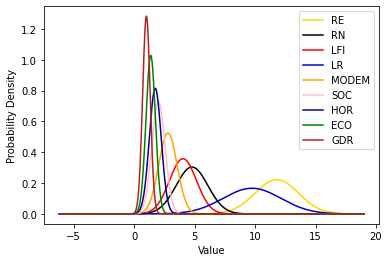

In [90]:
svs_1 = np.array([compute_semivalues(sim_mat.shape[0], theta, weights, lambda x:1/x) for weights in sampled_weights])
means_1, stds_1 = svs_1.mean(axis = 0), svs.std(axis = 0)
groups = ["RE", "RN", "LFI", "LR", "MODEM", "SOC", "HOR", "ECO", "GDR"]
plot_gaussians(means_1, stds_1, labels = groups)

In [91]:
groups = votes["groups"][:-2]
ea = np.array(votes["effectifs_assemblee"])[:-2]
es = np.array(votes["effectifs_senat"])[:-2]
effectifs = np.array([
    ea,
    es,
])
NUPES = [2,5,7,8]
ENSEMBLE = [0,4,6]


sim_mat = np.zeros((9,9))
np.fill_diagonal(sim_mat, 1)

for x in ENSEMBLE:
    for y in ENSEMBLE:
        sim_mat[x,y] = 1
        sim_mat[y,x] = 1
        
for x in NUPES:
    for y in NUPES:
        sim_mat[x,y] = 1
        sim_mat[y,x] = 1

for x in [i for i in range(9) if i not in [1,3]]:
    sim_mat[x,1] = 0
    sim_mat[1,x] = 0

sim_mat[0,3] = 1
sim_mat[3,0] = 1

In [92]:
groups

['Renaissance',
 'Rassemblement National',
 'La France insoumise - Nouvelle Union Populaire écologique et sociale',
 'Les Républicains',
 'Démocrate (MoDem et Indépendants)',
 'Socialistes et apparentés',
 'Horizons et apparentés',
 'Écologiste - NUPES',
 'Gauche démocrate et républicaine - NUPES']

In [93]:
cnns = find_connected_components(sim_mat)
cnns

[[0, 3, 4, 6], [1], [8, 2, 5, 7]]

In [94]:
data, theta = create_data(effectifs.shape[1],
                          lambda c:coalition_evaluation(c, effectifs, sim_mat, cnns),
                          k = 1
                          )

In [95]:
sigma_w = 1e-1
sigma_p = 1e-1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [06:41,  6.23it/s, step size=2.67e-02, acc. prob=0.732]


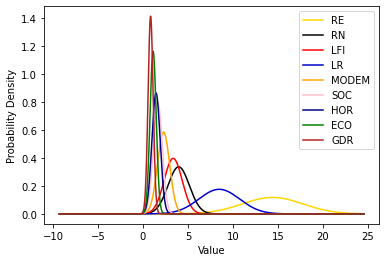

In [97]:
svs_2 = np.array([compute_semivalues(sim_mat.shape[0], theta, weights, lambda x:1/x) for weights in sampled_weights])
means_2, stds_2 = svs_2.mean(axis = 0), svs_2.std(axis = 0)
groups = ["RE", "RN", "LFI", "LR", "MODEM", "SOC", "HOR", "ECO", "GDR"]
plot_gaussians(means_2, stds_2, labels = groups)

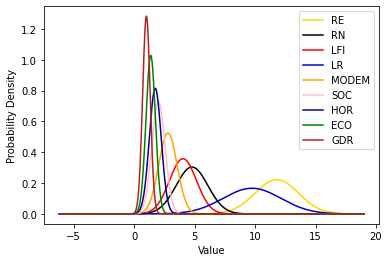

In [98]:
plot_gaussians(means_1, stds_1, labels = groups)

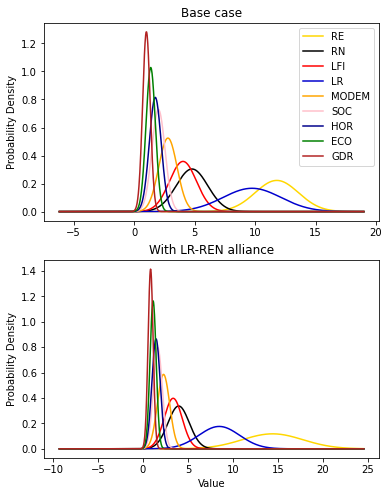

In [140]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
ax2.set_title("With LR-REN alliance")
ax1.set_title("Base case")
plot_gaussians(means_1, stds_1, labels = groups, fig = ax1)
plot_gaussians(means_2, stds_2, labels = None, fig = ax2)
ax1.legend()
ax1.set_ylabel('Probability Density')
ax2.set_xlabel('Value')
ax2.set_ylabel('Probability Density')
plt.savefig("LR-REN-Alliance.png")

In [142]:
for i,g in enumerate(groups):
    print(i,g)

0 RE
1 RN
2 LFI
3 LR
4 MODEM
5 SOC
6 HOR
7 ECO
8 GDR


In [143]:
probability_x_greater_than_y(means_1[0], stds_1[0], means_1[3], stds_1[3])

0.7536706139336783

In [144]:
probability_x_greater_than_y(means_2[0], stds_2[0], means_2[3], stds_2[3])

0.9278073131789394

In [145]:
probability_x_greater_than_y(means_1[3], stds_1[3], means_1[1], stds_1[1])

0.9652354158429265

In [146]:
probability_x_greater_than_y(means_2[3], stds_2[3], means_2[1], stds_2[1])

0.9613177954637454

In [110]:
groups = votes["groups"][:-2]
ea = np.array(votes["effectifs_assemblee"])[:-2]
es = np.array(votes["effectifs_senat"])[:-2]
effectifs = np.array([
    ea,
    es,
])
NUPES = [2,5,7,8]
ENSEMBLE = [0,4,6]


sim_mat = np.zeros((9,9))
np.fill_diagonal(sim_mat, 1)

for x in ENSEMBLE:
    for y in ENSEMBLE:
        sim_mat[x,y] = 1
        sim_mat[y,x] = 1
        
for x in NUPES:
    for y in NUPES:
        sim_mat[x,y] = 1
        sim_mat[y,x] = 1
        
for x in [i for i in range(9) if i not in [1,3]]:
    sim_mat[x,1] = 0
    sim_mat[1,x] = 0
cnns = find_connected_components(sim_mat)
cnns

[[0, 4, 6], [1], [8, 2, 7], [3], [5]]

In [112]:
data, theta = create_data(effectifs.shape[1],
                          lambda c:coalition_evaluation(c, effectifs, sim_mat, cnns),
                          k = 1
                          )

In [113]:
sigma_w = 1e-1
sigma_p = 1e-1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [03:34, 11.65it/s, step size=7.29e-02, acc. prob=0.675]


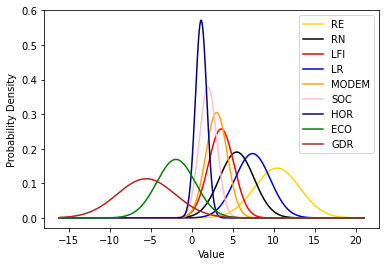

In [114]:
svs_3 = np.array([compute_semivalues(sim_mat.shape[0], theta, weights, lambda x:1/x) for weights in sampled_weights])
means_3, stds_3 = svs_3.mean(axis = 0), svs_3.std(axis = 0)
groups = ["RE", "RN", "LFI", "LR", "MODEM", "SOC", "HOR", "ECO", "GDR"]
plot_gaussians(means_3, stds_3, labels = groups)

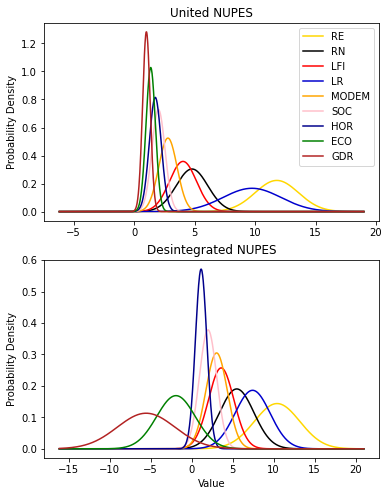

In [167]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
ax2.set_title("Desintegrated NUPES")
ax1.set_title("United NUPES")
plot_gaussians(means_1, stds_1, labels = groups, fig = ax1)
plot_gaussians(means_3, stds_3, labels = None, fig = ax2)
ax1.legend()
ax1.set_ylabel('Probability Density')
ax2.set_xlabel('Value')
ax2.set_ylabel('Probability Density')
plt.savefig("NUPES-Alliance.png")

In [152]:
groups = votes["groups"][:-2]
ea = np.array(votes["effectifs_assemblee"])[:-2]
es = np.array(votes["effectifs_senat"])[:-2]
effectifs = np.array([
    ea,
    es,
])
NUPES = [2,7,8]
ENSEMBLE = [0,4,6]


sim_mat = np.zeros((9,9))
np.fill_diagonal(sim_mat, 1)

for x in ENSEMBLE:
    for y in ENSEMBLE:
        sim_mat[x,y] = 1
        sim_mat[y,x] = 1
        
for x in NUPES:
    for y in NUPES:
        sim_mat[x,y] = 1
        sim_mat[y,x] = 1
        
for x in [i for i in range(9) if i not in [1,3]]:
    sim_mat[x,1] = 0
    sim_mat[1,x] = 0
cnns = find_connected_components(sim_mat)
cnns

[[0, 4, 6], [1], [8, 2, 7], [3], [5]]

In [153]:
data, theta = create_data(effectifs.shape[1],
                          lambda c:coalition_evaluation(c, effectifs, sim_mat, cnns),
                          k = 1)

In [154]:
sigma_w = 1e-1
sigma_p = 1e-1
n_samples = 1500

model = posterior_sampling_model(data, sigma_w=sigma_w, sigma_p=sigma_p)
diag, sampled_weights, sigmas = sample_model(model, data, "w", "sigma", warmup_steps=1000, num_samples=n_samples, return_diag=True)

Sample: 100%|████████████████████████████| 2500/2500 [06:30,  6.41it/s, step size=2.78e-02, acc. prob=0.803]


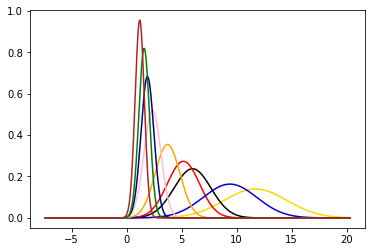

In [155]:
svs_4 = np.array([compute_semivalues(sim_mat.shape[0], theta, weights, lambda x:1/x) for weights in sampled_weights])
means_4, stds_4 = svs_4.mean(axis = 0), svs_4.std(axis = 0)
groups = ["RE", "RN", "LFI", "LR", "MODEM", "SOC", "HOR", "ECO", "GDR"]
plot_gaussians(means_4, stds_4, labels = groups)

In [174]:
mat2 = np.zeros((6,6))
for i1,p1 in enumerate([0,1,2,5,7,8]):
    for i2,p2 in enumerate([0,1,2,5,7,8]):
        p = probability_x_greater_than_y(means_1[p1], stds_1[p1], means_1[p2], stds_1[p2])
        if p > 0.5:
            print(f"{groups[p1]} > {groups[p2]} : {p}",)


RE > RN : 0.9992031927300087
RE > LFI : 0.9998814188457322
RE > SOC : 0.9999999112558171
RE > ECO : 0.9999999934251546
RE > GDR : 0.9999999984516046
RN > LFI : 0.6671596783024214
RN > SOC : 0.9744501196702126
RN > ECO : 0.9936735993497945
RN > GDR : 0.9974033605591549
LFI > SOC : 0.9490451941163802
LFI > ECO : 0.9881656139763911
LFI > GDR : 0.9955562514739384
SOC > ECO : 0.8292405253353397
SOC > GDR : 0.9430295000494514
ECO > GDR : 0.7636698478072839


In [175]:
mat2 = np.zeros((6,6))
for i1,p1 in enumerate([0,1,2,5,7,8]):
    for i2,p2 in enumerate([0,1,2,5,7,8]):
        p = probability_x_greater_than_y(means_3[p1], stds_3[p1], means_3[p2], stds_3[p2])
        if p > 0.5:
            print(f"{groups[p1]} > {groups[p2]} : {p}",)


RE > RN : 0.9215980133448782
RE > LFI : 0.9840969132161002
RE > SOC : 0.9977416945042896
RE > ECO : 0.9996475557119405
RE > GDR : 0.9998161560504474
RN > LFI : 0.7667987198780896
RN > SOC : 0.932217895576138
RN > ECO : 0.9905763288604095
RN > GDR : 0.9964854736105433
LFI > SOC : 0.8035694893778216
LFI > ECO : 0.974547351480211
LFI > GDR : 0.9912767837776889
SOC > ECO : 0.9348343837552425
SOC > GDR : 0.9799393676847814
ECO > GDR : 0.8046808410176474


In [168]:
for i,g in enumerate(groups):
    print(i,g)

0 RE
1 RN
2 LFI
3 LR
4 MODEM
5 SOC
6 HOR
7 ECO
8 GDR
